In [ ]:
!pip install wandb

In [ ]:
!pip install pyTelegramBotAPI

In [ ]:
import telebot

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense

import wandb
from wandb.keras import WandbCallback

import numpy as np
import cv2
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
import requests



In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:


wandb.init(project='classification model')



In [ ]:
config=wandb.config
config.learning_rate=0.0001

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path='/content/drive/MyDrive/images'

width=height=224

idg=ImageDataGenerator(
    
    rescale=1./255,

    #Augmentation
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=15,
    brightness_range=(0.9,1.1),
    validation_split=0.2
)

train_data=idg.flow_from_directory(
    dataset_path,
    target_size=(width,height),
    save_to_dir='/content/drive/MyDrive/datasets/augmented',
    class_mode='categorical',
    subset='training'


)

val_data=idg.flow_from_directory(
    dataset_path,
    target_size=(width,height),
    class_mode='categorical',
    subset='validation'


)

Found 709 images belonging to 4 classes.
Found 175 images belonging to 4 classes.


In [ ]:
model=tf.keras.models.Sequential([
      Conv2D(32,(3,3),activation='relu',input_shape=(width,height,3)),
      Conv2D(32,(3,3),activation='relu'),
      MaxPool2D(),
      Conv2D(32,(3,3),activation='relu'),
      Conv2D(32,(3,3),activation='relu'),
      MaxPool2D(),
      Conv2D(64,(3,3),activation='relu'),
      Conv2D(64,(3,3),activation='relu'),
      MaxPool2D(),

      Flatten(),
      Dense(256,activation='relu'),
      Dense(4,activation='softmax'),


])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


In [ ]:
#train
output=model.fit(train_data,validation_data=val_data,epochs=10,callbacks=[WandbCallback()])


Epoch 1/10
23/23 [==============================] - 67s 3s/step - loss: 1.3515 - accuracy: 0.3456 - val_loss: 1.2823 - val_accuracy: 0.4343 - _timestamp: 1647077516.0000 - _runtime: 78.0000
Epoch 2/10
23/23 [==============================] - 56s 2s/step - loss: 1.1585 - accuracy: 0.5035 - val_loss: 1.1657 - val_accuracy: 0.5029 - _timestamp: 1647077572.0000 - _runtime: 134.0000
Epoch 3/10
23/23 [==============================] - 54s 2s/step - loss: 0.9658 - accuracy: 0.5938 - val_loss: 1.0836 - val_accuracy: 0.5086 - _timestamp: 1647077627.0000 - _runtime: 189.0000
Epoch 4/10
23/23 [==============================] - 55s 2s/step - loss: 0.8246 - accuracy: 0.6629 - val_loss: 0.8434 - val_accuracy: 0.6629 - _timestamp: 1647077681.0000 - _runtime: 243.0000
Epoch 5/10
23/23 [==============================] - 54s 2s/step - loss: 0.7329 - accuracy: 0.7094 - val_loss: 0.7842 - val_accuracy: 0.6629 - _timestamp: 1647077736.0000 - _runtime: 298.0000
Epoch 6/10
23/23 [============================

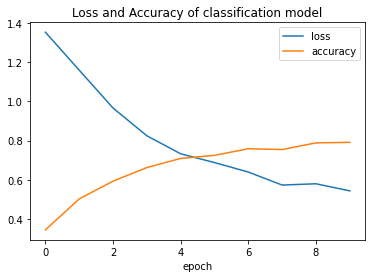

In [ ]:
plt.plot(output.history['loss'])
plt.plot(output.history['accuracy'])
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper right')
plt.title('Loss and Accuracy of classification model')
plt.show()

In [ ]:
dataset_path='/content/drive/MyDrive/datasets/classification/test'
idg=ImageDataGenerator(
    
    rescale=1./255,


)

test_data=idg.flow_from_directory(
    dataset_path,
    target_size=(width,height),
   
    class_mode='categorical',
    


)

Found 115 images belonging to 4 classes.


In [ ]:
#test
test_result=model.evaluate(test_data)


4/4 [==============================] - 1s 117ms/step - loss: 0.3490 - accuracy: 0.8696


In [ ]:
print(test_result)

[0.34895989298820496, 0.8695651888847351]


In [ ]:
image=cv2.imread('/content/drive/MyDrive/datasets/classification/house/suburban-house-royalty-free-image-1584972559.jpg')
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image=cv2.resize(image,(width,height))
image=image/255.0
image=image.reshape(1,width,height,3)

result=model.predict(image)

pred=np.argmax(result)

if pred==0:
  print('car')
elif pred==1:
  print('dress')
elif pred==2:
  print('house')
else:
  print('pizza')  



house


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.figure(figsize=(6,6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
  else:
        print('Confusion matrix, without normalization')

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
      
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')    

In [ ]:
target_names = []

for key in train_data.class_indices:
    target_names.append(key)

print(target_names)

['cars', 'dress', 'house', 'pizza']


Confusion Matrix
Normalized confusion matrix


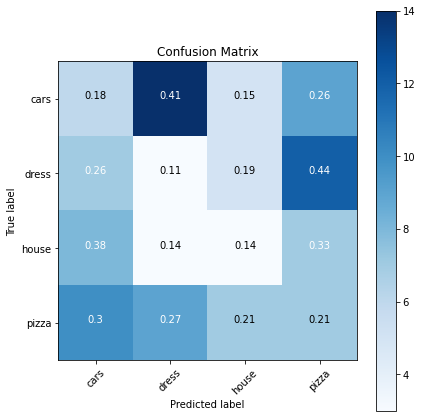

In [ ]:
#confusion mattix

Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(test_data.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix', normalize=True)